Using TensorFlow backend.



  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


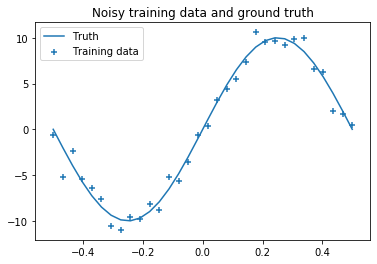

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from keras import activations, initializers
from keras.layers import Layer

import tensorflow as tf
import tensorflow_probability as tfp

%matplotlib inline

def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10 * np.sin(2 * np.pi * (x)) + epsilon

train_size = 32
noise = 1.0

X = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
y = f(X, sigma=noise)
y_true = f(X, sigma=0.0)

plt.scatter(X, y, marker='+', label='Training data')
plt.plot(X, y_true, label='Truth')
plt.title('Noisy training data and ground truth')
plt.legend();

In [12]:
X.shape

(32, 1)

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto() 
config.gpu_options.per_process_gpu_memory_fraction = 0.3 # 占用GPU90%的显存 
session = tf.Session(config=config)

In [4]:
print(tf.compat.v1.test.is_gpu_available())

False


In [9]:
def mixture_prior_params(sigma_1, sigma_2, pi, return_sigma=False):
    params = K.variable([sigma_1, sigma_2, pi], name='mixture_prior_params')
    sigma = np.sqrt(pi * sigma_1 ** 2 + (1 - pi) * sigma_2 ** 2)
    return params, sigma

def log_mixture_prior_prob(w):
    comp_1_dist = tfp.distributions.Normal(0.0, prior_params[0])
    comp_2_dist = tfp.distributions.Normal(0.0, prior_params[1])
    comp_1_weight = prior_params[2]    
    return K.log(comp_1_weight * comp_1_dist.prob(w) + (1 - comp_1_weight) * comp_2_dist.prob(w))    

# Mixture prior parameters shared across DenseVariational layer instances
prior_params, prior_sigma = mixture_prior_params(sigma_1=1.0, sigma_2=0.1, pi=0.2)

In [11]:
prior_sigma

0.4560701700396552

In [ ]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [5]:
class DenseVariational(Layer):
    def __init__(self, output_dim, kl_loss_weight, activation=None, **kwargs):
        self.output_dim = output_dim
        self.kl_loss_weight = kl_loss_weight
        self.activation = activations.get(activation)
        super().__init__(**kwargs)

    def build(self, input_shape):  
        self._trainable_weights.append(prior_params) 

        self.kernel_mu = self.add_weight(name='kernel_mu', 
                                         shape=(input_shape[1], self.output_dim),
                                         initializer=initializers.normal(stddev=prior_sigma),
                                         trainable=True)
        self.bias_mu = self.add_weight(name='bias_mu', 
                                       shape=(self.output_dim,),
                                       initializer=initializers.normal(stddev=prior_sigma),
                                       trainable=True)
        self.kernel_rho = self.add_weight(name='kernel_rho', 
                                          shape=(input_shape[1], self.output_dim),
                                          initializer=initializers.constant(0.0),
                                          trainable=True)
        self.bias_rho = self.add_weight(name='bias_rho', 
                                        shape=(self.output_dim,),
                                        initializer=initializers.constant(0.0),
                                        trainable=True)
        super().build(input_shape)

    def call(self, x):
        kernel_sigma = tf.math.softplus(self.kernel_rho)
        kernel = self.kernel_mu + kernel_sigma * tf.random.normal(self.kernel_mu.shape)

        bias_sigma = tf.math.softplus(self.bias_rho)
        bias = self.bias_mu + bias_sigma * tf.random.normal(self.bias_mu.shape)
                
        self.add_loss(self.kl_loss(kernel, self.kernel_mu, kernel_sigma) + 
                      self.kl_loss(bias, self.bias_mu, bias_sigma))
        
        return self.activation(K.dot(x, kernel) + bias)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def kl_loss(self, w, mu, sigma):
        variational_dist = tfp.distributions.Normal(mu, sigma)
        return kl_loss_weight * K.sum(variational_dist.log_prob(w) - log_mixture_prior_prob(w))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
from keras.layers import Input
from keras.models import Model

batch_size = train_size
num_batches = train_size / batch_size
kl_loss_weight = 1.0 / num_batches

x_in = Input(shape=(1,))
x = DenseVariational(20, kl_loss_weight=kl_loss_weight, activation='relu')(x_in)
x = DenseVariational(20, kl_loss_weight=kl_loss_weight, activation='relu')(x)
x = DenseVariational(1, kl_loss_weight=kl_loss_weight)(x)

model = Model(x_in, x)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [8]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_variational_1 (DenseVa (None, 20)                83        
_________________________________________________________________
dense_variational_2 (DenseVa (None, 20)                843       
_________________________________________________________________
dense_variational_3 (DenseVa (None, 1)                 45        
Total params: 965
Trainable params: 965
Non-trainable params: 0
_________________________________________________________________


In [15]:
from keras import callbacks, optimizers

def neg_log_likelihood(y_obs, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_obs))

model.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=0.03), metrics=['mse'])
model.fit(X, y, batch_size=batch_size, epochs=1500, verbose=1);

Epoch 1/1500
32/32 [==============================] - 1s 17ms/step - loss: 252.7246 - mse: 8.3761
Epoch 2/1500
32/32 [==============================] - 0s 156us/step - loss: 271.7225 - mse: 8.5817
Epoch 3/1500
32/32 [==============================] - 0s 141us/step - loss: 432.2337 - mse: 19.5402
Epoch 4/1500
32/32 [==============================] - 0s 138us/step - loss: 299.5752 - mse: 10.9023
Epoch 5/1500
32/32 [==============================] - 0s 147us/step - loss: 300.7024 - mse: 11.8437
Epoch 6/1500
32/32 [==============================] - 0s 288us/step - loss: 282.1589 - mse: 9.4834
Epoch 7/1500
32/32 [==============================] - 0s 155us/step - loss: 282.1868 - mse: 10.0196
Epoch 8/1500
32/32 [==============================] - 0s 143us/step - loss: 248.1147 - mse: 8.0690
Epoch 9/1500
32/32 [==============================] - 0s 142us/step - loss: 268.3594 - mse: 9.2022
Epoch 10/1500
32/32 [==============================] - 0s 137us/step - loss: 250.4052 - mse: 8.7333
Epoch 

Epoch 83/1500
32/32 [==============================] - 0s 111us/step - loss: 245.2124 - mse: 7.5980
Epoch 84/1500
32/32 [==============================] - 0s 101us/step - loss: 251.2616 - mse: 8.9220
Epoch 85/1500
32/32 [==============================] - 0s 108us/step - loss: 251.3822 - mse: 8.2872
Epoch 86/1500
32/32 [==============================] - 0s 105us/step - loss: 308.4640 - mse: 11.5262
Epoch 87/1500
32/32 [==============================] - 0s 106us/step - loss: 264.8896 - mse: 8.8767
Epoch 88/1500
32/32 [==============================] - 0s 89us/step - loss: 268.3062 - mse: 8.2233
Epoch 89/1500
32/32 [==============================] - 0s 108us/step - loss: 265.7657 - mse: 8.8235
Epoch 90/1500
32/32 [==============================] - 0s 97us/step - loss: 262.7505 - mse: 7.4507
Epoch 91/1500
32/32 [==============================] - 0s 106us/step - loss: 253.0090 - mse: 8.1967
Epoch 92/1500
32/32 [==============================] - 0s 94us/step - loss: 277.0348 - mse: 8.8052
Ep

Epoch 165/1500
32/32 [==============================] - 0s 86us/step - loss: 278.8400 - mse: 10.0782
Epoch 166/1500
32/32 [==============================] - 0s 85us/step - loss: 280.6458 - mse: 9.6004
Epoch 167/1500
32/32 [==============================] - 0s 77us/step - loss: 241.4539 - mse: 6.5421
Epoch 168/1500
32/32 [==============================] - 0s 83us/step - loss: 245.6852 - mse: 7.0552
Epoch 169/1500
32/32 [==============================] - 0s 86us/step - loss: 268.0938 - mse: 7.8922
Epoch 170/1500
32/32 [==============================] - 0s 82us/step - loss: 248.9514 - mse: 7.1540
Epoch 171/1500
32/32 [==============================] - 0s 84us/step - loss: 222.6920 - mse: 5.6976
Epoch 172/1500
32/32 [==============================] - 0s 81us/step - loss: 236.1678 - mse: 6.3406
Epoch 173/1500
32/32 [==============================] - 0s 81us/step - loss: 265.7718 - mse: 8.2252
Epoch 174/1500
32/32 [==============================] - 0s 77us/step - loss: 290.1475 - mse: 10.466

Epoch 247/1500
32/32 [==============================] - 0s 92us/step - loss: 242.6149 - mse: 5.9919
Epoch 248/1500
32/32 [==============================] - 0s 80us/step - loss: 242.2840 - mse: 5.2426
Epoch 249/1500
32/32 [==============================] - 0s 89us/step - loss: 233.0520 - mse: 5.1718
Epoch 250/1500
32/32 [==============================] - 0s 91us/step - loss: 267.7860 - mse: 7.9609
Epoch 251/1500
32/32 [==============================] - 0s 95us/step - loss: 273.7654 - mse: 8.3122
Epoch 252/1500
32/32 [==============================] - 0s 86us/step - loss: 240.3308 - mse: 6.4776
Epoch 253/1500
32/32 [==============================] - 0s 80us/step - loss: 211.0158 - mse: 3.8906
Epoch 254/1500
32/32 [==============================] - 0s 76us/step - loss: 242.2003 - mse: 4.9012
Epoch 255/1500
32/32 [==============================] - 0s 90us/step - loss: 284.9410 - mse: 8.9995
Epoch 256/1500
32/32 [==============================] - 0s 85us/step - loss: 241.3553 - mse: 6.4312


Epoch 329/1500
32/32 [==============================] - 0s 101us/step - loss: 230.5181 - mse: 4.6651
Epoch 330/1500
32/32 [==============================] - 0s 114us/step - loss: 224.1542 - mse: 4.3033
Epoch 331/1500
32/32 [==============================] - 0s 133us/step - loss: 242.5893 - mse: 4.9537
Epoch 332/1500
32/32 [==============================] - 0s 101us/step - loss: 204.3225 - mse: 4.0340
Epoch 333/1500
32/32 [==============================] - 0s 127us/step - loss: 220.0776 - mse: 4.2032
Epoch 334/1500
32/32 [==============================] - 0s 105us/step - loss: 192.6132 - mse: 2.4647
Epoch 335/1500
32/32 [==============================] - 0s 120us/step - loss: 200.8550 - mse: 3.3563
Epoch 336/1500
32/32 [==============================] - 0s 101us/step - loss: 212.7553 - mse: 3.3480
Epoch 337/1500
32/32 [==============================] - 0s 93us/step - loss: 226.3381 - mse: 4.8918
Epoch 338/1500
32/32 [==============================] - 0s 102us/step - loss: 212.8685 - mse

Epoch 411/1500
32/32 [==============================] - 0s 106us/step - loss: 188.6483 - mse: 2.1452
Epoch 412/1500
32/32 [==============================] - 0s 95us/step - loss: 205.4892 - mse: 3.2029
Epoch 413/1500
32/32 [==============================] - 0s 97us/step - loss: 222.6480 - mse: 4.5251
Epoch 414/1500
32/32 [==============================] - 0s 102us/step - loss: 232.8935 - mse: 4.5453
Epoch 415/1500
32/32 [==============================] - 0s 102us/step - loss: 190.4257 - mse: 2.6160
Epoch 416/1500
32/32 [==============================] - 0s 111us/step - loss: 203.3153 - mse: 3.0187
Epoch 417/1500
32/32 [==============================] - 0s 112us/step - loss: 205.7990 - mse: 3.2570
Epoch 418/1500
32/32 [==============================] - 0s 106us/step - loss: 220.6163 - mse: 3.3268
Epoch 419/1500
32/32 [==============================] - 0s 122us/step - loss: 264.7701 - mse: 7.6953
Epoch 420/1500
32/32 [==============================] - 0s 122us/step - loss: 188.7877 - mse:

Epoch 493/1500
32/32 [==============================] - 0s 84us/step - loss: 213.6003 - mse: 2.9366
Epoch 494/1500
32/32 [==============================] - 0s 95us/step - loss: 207.6973 - mse: 2.0811
Epoch 495/1500
32/32 [==============================] - 0s 98us/step - loss: 188.6145 - mse: 1.5787
Epoch 496/1500
32/32 [==============================] - 0s 103us/step - loss: 201.8262 - mse: 1.8152
Epoch 497/1500
32/32 [==============================] - 0s 96us/step - loss: 192.8305 - mse: 2.1028
Epoch 498/1500
32/32 [==============================] - 0s 100us/step - loss: 200.5885 - mse: 1.8289
Epoch 499/1500
32/32 [==============================] - 0s 102us/step - loss: 201.2278 - mse: 2.0174
Epoch 500/1500
32/32 [==============================] - 0s 108us/step - loss: 200.2340 - mse: 1.5373
Epoch 501/1500
32/32 [==============================] - 0s 90us/step - loss: 208.4461 - mse: 3.4197
Epoch 502/1500
32/32 [==============================] - 0s 105us/step - loss: 204.4643 - mse: 3.

Epoch 575/1500
32/32 [==============================] - 0s 93us/step - loss: 183.5223 - mse: 1.8016
Epoch 576/1500
32/32 [==============================] - 0s 90us/step - loss: 193.6030 - mse: 2.0096
Epoch 577/1500
32/32 [==============================] - 0s 96us/step - loss: 209.6295 - mse: 2.4969
Epoch 578/1500
32/32 [==============================] - 0s 96us/step - loss: 174.0375 - mse: 1.5491
Epoch 579/1500
32/32 [==============================] - 0s 93us/step - loss: 177.3770 - mse: 1.2707
Epoch 580/1500
32/32 [==============================] - 0s 93us/step - loss: 182.5863 - mse: 2.9111
Epoch 581/1500
32/32 [==============================] - 0s 104us/step - loss: 197.0357 - mse: 2.2916
Epoch 582/1500
32/32 [==============================] - 0s 91us/step - loss: 189.9863 - mse: 3.1832
Epoch 583/1500
32/32 [==============================] - 0s 102us/step - loss: 174.7728 - mse: 1.1616
Epoch 584/1500
32/32 [==============================] - 0s 116us/step - loss: 182.4344 - mse: 1.44

Epoch 657/1500
32/32 [==============================] - 0s 104us/step - loss: 207.4363 - mse: 3.0963
Epoch 658/1500
32/32 [==============================] - 0s 112us/step - loss: 182.6759 - mse: 1.3621
Epoch 659/1500
32/32 [==============================] - 0s 110us/step - loss: 169.8703 - mse: 1.3529
Epoch 660/1500
32/32 [==============================] - 0s 99us/step - loss: 191.0011 - mse: 1.3184
Epoch 661/1500
32/32 [==============================] - 0s 101us/step - loss: 186.9834 - mse: 2.0591
Epoch 662/1500
32/32 [==============================] - 0s 108us/step - loss: 168.8457 - mse: 0.8915
Epoch 663/1500
32/32 [==============================] - 0s 101us/step - loss: 182.9199 - mse: 1.3237
Epoch 664/1500
32/32 [==============================] - 0s 99us/step - loss: 181.8983 - mse: 1.5768
Epoch 665/1500
32/32 [==============================] - 0s 95us/step - loss: 190.3121 - mse: 1.9274
Epoch 666/1500
32/32 [==============================] - 0s 90us/step - loss: 174.4691 - mse: 1

Epoch 739/1500
32/32 [==============================] - 0s 95us/step - loss: 169.7275 - mse: 1.1397
Epoch 740/1500
32/32 [==============================] - 0s 95us/step - loss: 183.6620 - mse: 1.9676
Epoch 741/1500
32/32 [==============================] - 0s 88us/step - loss: 177.0483 - mse: 1.0256
Epoch 742/1500
32/32 [==============================] - 0s 89us/step - loss: 203.6225 - mse: 3.1797
Epoch 743/1500
32/32 [==============================] - 0s 89us/step - loss: 180.0872 - mse: 1.9272
Epoch 744/1500
32/32 [==============================] - 0s 81us/step - loss: 192.9394 - mse: 2.0916
Epoch 745/1500
32/32 [==============================] - 0s 80us/step - loss: 184.6287 - mse: 1.9977
Epoch 746/1500
32/32 [==============================] - 0s 92us/step - loss: 191.8541 - mse: 2.3253
Epoch 747/1500
32/32 [==============================] - 0s 89us/step - loss: 188.9672 - mse: 1.9545
Epoch 748/1500
32/32 [==============================] - 0s 110us/step - loss: 171.2460 - mse: 1.4959

Epoch 821/1500
32/32 [==============================] - 0s 88us/step - loss: 183.2343 - mse: 1.4508
Epoch 822/1500
32/32 [==============================] - 0s 85us/step - loss: 184.9061 - mse: 1.1656
Epoch 823/1500
32/32 [==============================] - 0s 84us/step - loss: 191.1785 - mse: 2.0991
Epoch 824/1500
32/32 [==============================] - 0s 94us/step - loss: 183.2901 - mse: 1.5915
Epoch 825/1500
32/32 [==============================] - 0s 93us/step - loss: 173.8281 - mse: 1.8852
Epoch 826/1500
32/32 [==============================] - 0s 90us/step - loss: 187.8524 - mse: 2.7258
Epoch 827/1500
32/32 [==============================] - 0s 89us/step - loss: 192.3260 - mse: 2.3255
Epoch 828/1500
32/32 [==============================] - 0s 104us/step - loss: 495.5750 - mse: 20.5311
Epoch 829/1500
32/32 [==============================] - 0s 97us/step - loss: 180.0780 - mse: 1.6151
Epoch 830/1500
32/32 [==============================] - 0s 89us/step - loss: 174.7968 - mse: 1.491

Epoch 903/1500
32/32 [==============================] - 0s 98us/step - loss: 182.8802 - mse: 2.1042
Epoch 904/1500
32/32 [==============================] - 0s 106us/step - loss: 190.8396 - mse: 1.6243
Epoch 905/1500
32/32 [==============================] - 0s 108us/step - loss: 192.2968 - mse: 1.5604
Epoch 906/1500
32/32 [==============================] - 0s 112us/step - loss: 203.6231 - mse: 3.4120
Epoch 907/1500
32/32 [==============================] - 0s 118us/step - loss: 211.2549 - mse: 3.3155
Epoch 908/1500
32/32 [==============================] - 0s 110us/step - loss: 189.5214 - mse: 1.9123
Epoch 909/1500
32/32 [==============================] - 0s 111us/step - loss: 189.4118 - mse: 2.2207
Epoch 910/1500
32/32 [==============================] - 0s 116us/step - loss: 203.9785 - mse: 2.9202
Epoch 911/1500
32/32 [==============================] - 0s 98us/step - loss: 195.0110 - mse: 1.7126
Epoch 912/1500
32/32 [==============================] - 0s 90us/step - loss: 201.5555 - mse: 

Epoch 985/1500
32/32 [==============================] - 0s 100us/step - loss: 192.3599 - mse: 2.2119
Epoch 986/1500
32/32 [==============================] - 0s 89us/step - loss: 168.9264 - mse: 1.4312
Epoch 987/1500
32/32 [==============================] - 0s 95us/step - loss: 175.2892 - mse: 1.5606
Epoch 988/1500
32/32 [==============================] - 0s 101us/step - loss: 181.6537 - mse: 1.9195
Epoch 989/1500
32/32 [==============================] - 0s 84us/step - loss: 165.3883 - mse: 1.5395
Epoch 990/1500
32/32 [==============================] - 0s 89us/step - loss: 235.6187 - mse: 5.2588
Epoch 991/1500
32/32 [==============================] - 0s 94us/step - loss: 195.3798 - mse: 2.7009
Epoch 992/1500
32/32 [==============================] - 0s 89us/step - loss: 202.1396 - mse: 3.1098
Epoch 993/1500
32/32 [==============================] - 0s 112us/step - loss: 177.1858 - mse: 1.8785
Epoch 994/1500
32/32 [==============================] - 0s 112us/step - loss: 190.0911 - mse: 2.2

32/32 [==============================] - 0s 89us/step - loss: 197.2460 - mse: 2.2741
Epoch 1067/1500
32/32 [==============================] - 0s 64us/step - loss: 227.1915 - mse: 4.4032
Epoch 1068/1500
32/32 [==============================] - 0s 63us/step - loss: 187.3708 - mse: 1.6839
Epoch 1069/1500
32/32 [==============================] - 0s 64us/step - loss: 180.6307 - mse: 1.7005
Epoch 1070/1500
32/32 [==============================] - 0s 60us/step - loss: 187.3643 - mse: 1.9954
Epoch 1071/1500
32/32 [==============================] - 0s 62us/step - loss: 171.6364 - mse: 1.3595
Epoch 1072/1500
32/32 [==============================] - 0s 61us/step - loss: 200.7711 - mse: 2.6916
Epoch 1073/1500
32/32 [==============================] - 0s 61us/step - loss: 203.8299 - mse: 3.0700
Epoch 1074/1500
32/32 [==============================] - 0s 59us/step - loss: 186.8301 - mse: 1.7640
Epoch 1075/1500
32/32 [==============================] - 0s 57us/step - loss: 195.6740 - mse: 2.5363
Epoch 

Epoch 1148/1500
32/32 [==============================] - 0s 81us/step - loss: 188.7349 - mse: 1.0255
Epoch 1149/1500
32/32 [==============================] - 0s 93us/step - loss: 235.9648 - mse: 4.2143
Epoch 1150/1500
32/32 [==============================] - 0s 83us/step - loss: 179.8342 - mse: 1.6199
Epoch 1151/1500
32/32 [==============================] - 0s 94us/step - loss: 194.0919 - mse: 2.0616
Epoch 1152/1500
32/32 [==============================] - 0s 86us/step - loss: 190.8103 - mse: 2.1467
Epoch 1153/1500
32/32 [==============================] - 0s 74us/step - loss: 223.5460 - mse: 3.8440
Epoch 1154/1500
32/32 [==============================] - 0s 90us/step - loss: 199.0035 - mse: 2.8232
Epoch 1155/1500
32/32 [==============================] - 0s 98us/step - loss: 194.9099 - mse: 2.4283
Epoch 1156/1500
32/32 [==============================] - 0s 73us/step - loss: 190.6445 - mse: 2.4470
Epoch 1157/1500
32/32 [==============================] - 0s 119us/step - loss: 175.3872 - m

Epoch 1229/1500
32/32 [==============================] - 0s 121us/step - loss: 211.1196 - mse: 2.9278
Epoch 1230/1500
32/32 [==============================] - 0s 110us/step - loss: 192.3723 - mse: 3.0928
Epoch 1231/1500
32/32 [==============================] - 0s 97us/step - loss: 188.8461 - mse: 2.4210
Epoch 1232/1500
32/32 [==============================] - 0s 93us/step - loss: 189.5058 - mse: 1.8337
Epoch 1233/1500
32/32 [==============================] - 0s 97us/step - loss: 242.4512 - mse: 6.4529
Epoch 1234/1500
32/32 [==============================] - 0s 109us/step - loss: 191.0722 - mse: 1.8699
Epoch 1235/1500
32/32 [==============================] - 0s 111us/step - loss: 187.7622 - mse: 1.7501
Epoch 1236/1500
32/32 [==============================] - 0s 123us/step - loss: 206.8532 - mse: 2.3594
Epoch 1237/1500
32/32 [==============================] - 0s 118us/step - loss: 183.7952 - mse: 1.8624
Epoch 1238/1500
32/32 [==============================] - 0s 109us/step - loss: 216.31

Epoch 1310/1500
32/32 [==============================] - 0s 90us/step - loss: 171.4026 - mse: 1.0236
Epoch 1311/1500
32/32 [==============================] - 0s 96us/step - loss: 195.1048 - mse: 2.3950
Epoch 1312/1500
32/32 [==============================] - 0s 90us/step - loss: 188.6228 - mse: 2.2293
Epoch 1313/1500
32/32 [==============================] - 0s 93us/step - loss: 235.2676 - mse: 4.9743
Epoch 1314/1500
32/32 [==============================] - 0s 106us/step - loss: 191.4638 - mse: 1.7426
Epoch 1315/1500
32/32 [==============================] - 0s 94us/step - loss: 200.4069 - mse: 2.9775
Epoch 1316/1500
32/32 [==============================] - 0s 99us/step - loss: 199.8000 - mse: 2.5267
Epoch 1317/1500
32/32 [==============================] - 0s 85us/step - loss: 178.1133 - mse: 1.3420
Epoch 1318/1500
32/32 [==============================] - 0s 80us/step - loss: 216.2389 - mse: 3.2829
Epoch 1319/1500
32/32 [==============================] - 0s 78us/step - loss: 189.8830 - m

Epoch 1391/1500
32/32 [==============================] - 0s 126us/step - loss: 208.6311 - mse: 2.7446
Epoch 1392/1500
32/32 [==============================] - 0s 167us/step - loss: 179.1353 - mse: 1.2568
Epoch 1393/1500
32/32 [==============================] - 0s 113us/step - loss: 273.7886 - mse: 8.3752
Epoch 1394/1500
32/32 [==============================] - 0s 101us/step - loss: 185.0314 - mse: 1.7264
Epoch 1395/1500
32/32 [==============================] - 0s 104us/step - loss: 194.8060 - mse: 1.9969
Epoch 1396/1500
32/32 [==============================] - 0s 101us/step - loss: 192.8954 - mse: 2.6366
Epoch 1397/1500
32/32 [==============================] - 0s 101us/step - loss: 215.1479 - mse: 3.3201
Epoch 1398/1500
32/32 [==============================] - 0s 109us/step - loss: 180.8470 - mse: 1.3271
Epoch 1399/1500
32/32 [==============================] - 0s 145us/step - loss: 369.7463 - mse: 13.5120
Epoch 1400/1500
32/32 [==============================] - 0s 106us/step - loss: 17

Epoch 1472/1500
32/32 [==============================] - 0s 90us/step - loss: 206.8476 - mse: 2.7027
Epoch 1473/1500
32/32 [==============================] - 0s 100us/step - loss: 180.2484 - mse: 1.2243
Epoch 1474/1500
32/32 [==============================] - 0s 108us/step - loss: 183.7152 - mse: 1.4511
Epoch 1475/1500
32/32 [==============================] - 0s 95us/step - loss: 194.7201 - mse: 2.1446
Epoch 1476/1500
32/32 [==============================] - 0s 107us/step - loss: 191.0482 - mse: 1.9368
Epoch 1477/1500
32/32 [==============================] - 0s 98us/step - loss: 213.1235 - mse: 2.0915
Epoch 1478/1500
32/32 [==============================] - 0s 90us/step - loss: 215.2411 - mse: 3.0174
Epoch 1479/1500
32/32 [==============================] - 0s 90us/step - loss: 202.6484 - mse: 2.3664
Epoch 1480/1500
32/32 [==============================] - 0s 116us/step - loss: 176.8397 - mse: 1.3592
Epoch 1481/1500
32/32 [==============================] - 0s 99us/step - loss: 188.7730 

In [24]:
#print({l.name: l.weights for l in model.layers})
#model.layers[1].get_weights()
model.layers[1].weights

[<tf.Variable 'mixture_prior_params:0' shape=(3,) dtype=float32>,
 <tf.Variable 'dense_variational_1/kernel_mu:0' shape=(1, 20) dtype=float32>,
 <tf.Variable 'dense_variational_1/bias_mu:0' shape=(20,) dtype=float32>,
 <tf.Variable 'dense_variational_1/kernel_rho:0' shape=(1, 20) dtype=float32>,
 <tf.Variable 'dense_variational_1/bias_rho:0' shape=(20,) dtype=float32>]

100%|██████████| 500/500 [00:16<00:00, 29.63it/s]


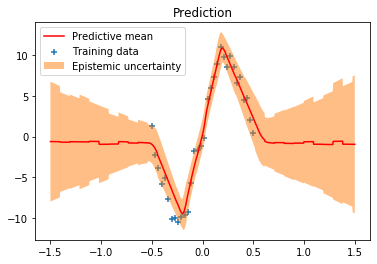

In [7]:
import tqdm

X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
y_pred_list = []

for i in tqdm.tqdm(range(500)):
    y_pred = model.predict(X_test)
    y_pred_list.append(y_pred)
    
y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

plt.plot(X_test, y_mean, 'r-', label='Predictive mean');
plt.scatter(X, y, marker='+', label='Training data')
plt.fill_between(X_test.ravel(), 
                 y_mean + 2 * y_sigma, 
                 y_mean - 2 * y_sigma, 
                 alpha=0.5, label='Epistemic uncertainty')
plt.title('Prediction')
plt.legend();